In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [2]:
NASDAQ = yf.Ticker("^IXIC")

In [3]:
# get historical market data
hist = NASDAQ.history(start="1971-01-01")

In [4]:
dataset = hist[['Open', 'High','Low','Close','Volume']]

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1971-02-05,100.00,100.00,100.00,100.00,0,0,0
1971-02-08,100.84,100.84,100.84,100.84,0,0,0
1971-02-09,100.76,100.76,100.76,100.76,0,0,0
1971-02-10,100.69,100.69,100.69,100.69,0,0,0
1971-02-11,101.45,101.45,101.45,101.45,0,0,0


In [5]:
dataset = dataset.reset_index()

In [6]:
dataset.rename(columns={'Date':'index','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'},inplace=True)

In [7]:
dataset = dataset[['index','open','close','high','low','volume']]

In [9]:
dataset = dataset.sort_values(by = ['index'], ascending=True)
#dataset= dataset.transpose()
dataset.head()

,index,open,close,high,low,volume
0,1971-02-05,100.00,100.00,100.00,100.00,0
1,1971-02-08,100.84,100.84,100.84,100.84,0
2,1971-02-09,100.76,100.76,100.76,100.76,0
3,1971-02-10,100.69,100.69,100.69,100.69,0
4,1971-02-11,101.45,101.45,101.45,101.45,0


In [10]:
dataset.tail()

,index,open,close,high,low,volume
12432,2020-05-21,9375.19,9284.88,9405.25,9254.85,3725950000
12433,2020-05-22,9278.55,9324.59,9328.28,9239.41,3641830000
12434,2020-05-26,9501.21,9340.22,9501.21,9333.16,4432310000
12435,2020-05-27,9346.12,9412.36,9414.62,9144.28,4462450000
12436,2020-05-28,9392.99,9368.99,9523.64,9345.28,4064220000


In [11]:
p = dataset['open'].rolling(window=2).mean()
p.head()

0        NaN
1    100.420
2    100.800
3    100.725
4    101.070
Name: open, dtype: float64

In [12]:
dataset['ma1'] = p.diff()
dataset['ma2'] = dataset['ma1'].diff()
dataset['ma3'] = dataset['ma2'].diff()
dataset['HL'] = (dataset['high'] - dataset['low']) / dataset['close'] * 100
dataset['pct_change'] = (dataset['close'] - dataset['open'])/dataset['open'] * 100
dataset['vol_increment'] = dataset.volume.diff() / dataset.volume
dataset["vol_roc"] = dataset.volume.diff() / dataset.volume
dataset["open1"] = dataset.open.shift(1)
dataset["open_increment"] = dataset.open - dataset.open.shift(1)
print(dataset.head())

       index    open   close    high     low  volume    ma1    ma2    ma3  \
0 1971-02-05  100.00  100.00  100.00  100.00       0    NaN    NaN    NaN   
1 1971-02-08  100.84  100.84  100.84  100.84       0    NaN    NaN    NaN   
2 1971-02-09  100.76  100.76  100.76  100.76       0  0.380    NaN    NaN   
3 1971-02-10  100.69  100.69  100.69  100.69       0 -0.075 -0.455    NaN   
4 1971-02-11  101.45  101.45  101.45  101.45       0  0.345  0.420  0.875   

    HL  pct_change  vol_increment  vol_roc   open1  open_increment  
0  0.0         0.0            NaN      NaN     NaN             NaN  
1  0.0         0.0            NaN      NaN  100.00            0.84  
2  0.0         0.0            NaN      NaN  100.84           -0.08  
3  0.0         0.0            NaN      NaN  100.76           -0.07  
4  0.0         0.0            NaN      NaN  100.69            0.76  


In [13]:
dataset2 = dataset[['ma1','ma2','ma3','HL','pct_change','vol_increment','vol_roc','open1','open_increment','open']]
dataset2.head()

,ma1,ma2,ma3,HL,pct_change,vol_increment,vol_roc,open1,open_increment,open
0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.00
1,NaN,NaN,NaN,0.0,0.0,NaN,NaN,100.00,0.84,100.84
2,0.380,NaN,NaN,0.0,0.0,NaN,NaN,100.84,-0.08,100.76
3,-0.075,-0.455,NaN,0.0,0.0,NaN,NaN,100.76,-0.07,100.69
4,0.345,0.420,0.875,0.0,0.0,NaN,NaN,100.69,0.76,101.45


In [14]:
dataset2.fillna(-99999, inplace=True)
dataset2.head()

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,ma1,ma2,ma3,HL,pct_change,vol_increment,vol_roc,open1,open_increment,open
0,-99999.000,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,-99999.00,-99999.00,100.00
1,-99999.000,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,100.00,0.84,100.84
2,0.380,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,100.84,-0.08,100.76
3,-0.075,-0.455,-99999.000,0.0,0.0,-99999.0,-99999.0,100.76,-0.07,100.69
4,0.345,0.420,0.875,0.0,0.0,-99999.0,-99999.0,100.69,0.76,101.45


In [15]:
dataset2['target']= (dataset2.ma1.shift(-1) - dataset2.ma1).dropna()
dataset2.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ma1,ma2,ma3,HL,pct_change,vol_increment,vol_roc,open1,open_increment,open,target
0,-99999.000,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,-99999.00,-99999.00,100.00,0.000
1,-99999.000,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,100.00,0.84,100.84,99999.380
2,0.380,-99999.000,-99999.000,0.0,0.0,-99999.0,-99999.0,100.84,-0.08,100.76,-0.455
3,-0.075,-0.455,-99999.000,0.0,0.0,-99999.0,-99999.0,100.76,-0.07,100.69,0.420
4,0.345,0.420,0.875,0.0,0.0,-99999.0,-99999.0,100.69,0.76,101.45,0.335


[Text(0.5, 0, 'ma1'),
 Text(1.5, 0, 'ma2'),
 Text(2.5, 0, 'ma3'),
 Text(3.5, 0, 'HL'),
 Text(4.5, 0, 'pct_change'),
 Text(5.5, 0, 'vol_increment'),
 Text(6.5, 0, 'vol_roc'),
 Text(7.5, 0, 'open1'),
 Text(8.5, 0, 'open_increment'),
 Text(9.5, 0, 'open'),
 Text(10.5, 0, 'target')]

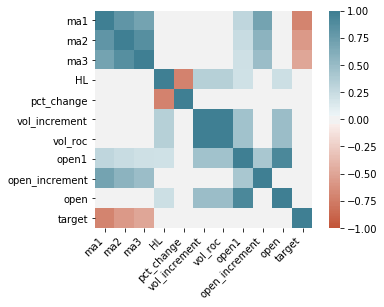

In [16]:
corr = dataset2.corr()
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [17]:
print('Total dataset has {} samples, and {} features.'.format(dataset2.shape[0],dataset2.shape[1]))

Total dataset has 12437 samples, and 11 features.


In [18]:
X = (dataset2.drop(['target'],1))
y = dataset2['target']
print(len(X), len(y))

12437 12437


In [19]:
train_samples = int(X.shape[0] * 0.95)

X_train = X[:train_samples]
X_test = X[train_samples:]

y_train = y[:train_samples]
y_test = y[train_samples:]

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11815, 10) (11815,)
(622, 10) (622,)


In [21]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
y_test_binary = y_test.apply(getBinary)

In [22]:
regressor = xgb.XGBRegressor(objective='reg:squarederror'
                             ,gamma=0.0,n_estimators = 200,
                             base_score = 0.7,colsample_bytree=1,
                             learning_rate=0.01)

In [23]:
xgb_model = regressor.fit(X_train, y_train.apply(getBinary))
y_predicted = xgb_model.predict(X_test)
y_predicted_binary = [1 if yp >= 0.5 else 0 for yp in y_predicted]
print(accuracy_score(y_test_binary,y_predicted_binary))

0.8118971061093248


<Figure size 720x576 with 0 Axes>

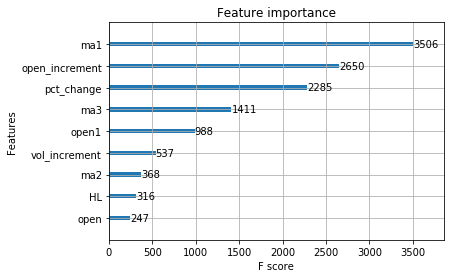

In [24]:
fig = plt.figure(figsize=(10,8))

# Plot feature importance
plot_importance(xgb_model)
plt.show()

In [35]:
x_input = X_test[-20:]
marchPrices = xgb_model.predict(x_input)

Price of stock on March 3, 2020: $ 0.8005504


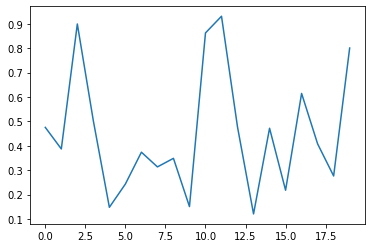

In [36]:
plt.plot(marchPrices)
plt.show()